### Noisy integrate-and-fire neurons

Prior to this point, we have consider IF models whose inputs are *deterministic*, in which case (when considering linear models) we can solve precisely for the evolution of the voltage over time. When inputs to the IF model are *noisy*, we must take a different approach in which we can only describe the probability of a certain trajectory _or_ we can just look at the dynamics of a single *realization* (or instance) of noise to the model.

To start, note that now, we're going to consider a leaky integrate and fire model receiving both constant $\bar{I}$ and noisy $I_{\rm noise}(t)$ input:
$$
\frac{du}{dt} = - \alpha u + \bar{I} + I_{\rm noise}(t), \ \ \ \ \ \ \ {\rm if} \ u(T) = \theta, \ u(T^+) \mapsto 0,
$$
where $\alpha = 1/\tau$ now accounts for the rate of the leak, input is scaled by capacitance, we have shifted the resting potential to be zero, and $\theta$ is the threshold. We consider $I_{\rm noise}(t)$ that takes the form of *white noise* with unit variance. One way to understand the white noise, is to see how the above equation is implemented using a *stochastic* version of Euler's method, where
$$
u(t + \Delta t) = u(t) + \Delta t (-\alpha u(t) + \bar{I}) + \sqrt{2 \Delta t} {\mathcal N}(0,1).
$$
Here, the final term ${\mathcal N}(0,1)$ represents a normal random variable, which can be implemented in python using the command numpy.random.randn():

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

rnd.randn()

0.54454784953013

Note, each time we run rnd.randn(), a different random number will be generated, drawn from a normal distribution:

In [3]:
rnd.rand()

0.029748876097981602

We can go a step further by allowing the variance of the normal random variable to be a constant $\sigma^2$, which is done by scaling the result by $\sigma$ (the standard deviation), so for instance, if we want $\sigma = 0.1$ in ${\mathcal N}(0,\sigma^2)$.

In [4]:
s = 0.1
s*rnd.rand()

0.04208710388610827

As before, each time we draw a random variable, it will be different. This means that each time the noisy IF model above is simulated, there will be a different random sequence of input kicks over time, meaning each simulation will lead to a different voltage trajectory -- this is much more like how neurons in the brain behaves, since they are constantly receiving a barrage of background noisy input. With this in mind, we now program the noisy leaky integrate-and-fire model and see how voltage trajectories and spike times look.

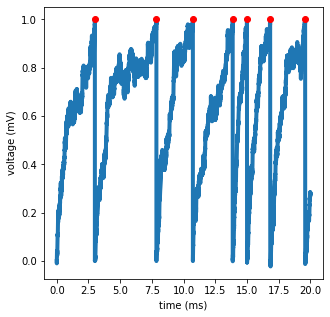

In [5]:
alf = 1    # membrane time constant (ms)\
I = 0.95       # capacitance scaled input current (mA/F)
th = 1     # spiking threshold (mV)
s = 0.1      # noise standard deviation

T = 20      # total time to run
dt = 0.001   # time step
nt = int(np.round(T/dt)+1)     # number of entries in vector array
tvec = np.linspace(0,T,nt)     # time vector (ms)

u = np.zeros(nt)   # vector of voltage entries (mV)
st = []             # initialize vector of spike times (ms)

for j in np.arange(nt-1):
    u[j+1] = u[j]+dt*(I-alf*u[j])+np.sqrt(2*dt)*s*rnd.randn();
    if u[j+1]>th:
        u[j+1]=0;                   # reset the voltage to resting potential
        st = np.append(st,tvec[j+1])    # add on another spike time
        
fig = plt.figure(figsize=(5,5))  # initialize figure with a given area in inches
plt.plot(tvec,u,linewidth=4.0)  # plot command with vectors as arguments
plt.plot(st,np.full_like(st,th),'ro')
plt.xlabel('time (ms)')         # label for x-axis
plt.ylabel('voltage (mV)')      # label for y-axis
plt.show()                      # needed in order to actually produce the plot for you to see

Notice, in the above, depending on what we make the noise variance $\sigma^2$, the frequency of spikes changes. Though it is not straightforward to see in a single simulation, the larger $\sigma^2$ is, the higher the spike frequency because it is simply more probable that a very noisy trajectory will hit the threshold.

Note, we are saving the spike times as a vector in the above simulation. This data can be analyzed to get a sense of how varying parameters influences spike statistics. First, we can simply find the average rate of spiking. More generally, we can find the distribution of spike times. However, to do this, we need sufficient statistics, and so must run our simulation a lot longer.

In [6]:
alf = 1    # membrane time constant (ms)\
I = 0.95       # capacitance scaled input current (mA/F)
th = 1     # spiking threshold (mV)
s = 0.1      # noise standard deviation

T = 20000      # total time to run
dt = 0.01   # time step
nt = int(np.round(T/dt)+1)     # number of entries in vector array
tvec = np.linspace(0,T,nt)     # time vector (ms)

u = np.zeros(nt)   # vector of voltage entries (mV)
st = []             # initialize vector of spike times (ms)

for j in np.arange(nt-1):
    u[j+1] = u[j]+dt*(I-alf*u[j])+np.sqrt(2*dt)*s*rnd.randn();
    if u[j+1]>th:
        u[j+1]=0;                   # reset the voltage to resting potential
        st = np.append(st,tvec[j+1])    # add on another spike time

Now, to find the mean spike rate, we simply average the time between spikes and take the inverse.

In [7]:
isi = np.diff(st)
mst = np.mean(isi)
mr = 1/mst
print(mr)

0.26121334423597725


We can also compute the variance of the spike intervals, which tells us how much spread there is in the distribution of interspike interval values.

In [8]:
vst = np.var(isi)
print(vst)

2.9669107979628464


A slightly more straightforward way to get the above statistics is to specify the number of spikes we wish to see ahead of time. Then, we know how many data points will go into computing mean and variance. To do this, we run multiple simulations that always start over at the initial voltage value zero, as follows. Note also, we do not really need to save the vector of voltages each time, as we're only interested in the spike time.

In [9]:
alf = 1    # membrane time constant (ms)\
I = 0.95       # capacitance scaled input current (mA/F)
th = 1     # spiking threshold (mV)
s = 0.1      # noise standard deviation

Nsim = 1000      # total number of simulations to run to obtain isi data
dt = 0.01   # time step
isi = np.zeros(Nsim)             # initialize vector of spike times (ms)

for j in np.arange(Nsim):
    u=0
    t=0
    while u<th:
        u =u+dt*(I-alf*u)+np.sqrt(2*dt)*s*rnd.randn();
        t=t+dt
    isi[j-1]=t

Then, we can compute mean and variance as before.

In [10]:
mst = np.mean(isi)
mr = 1/mst
print(mr)

vst = np.var(isi)
print(vst)

0.2622641262015001
3.050249197499872


But let's go one step further and plot a histogram of spike times using `hist' command.

(array([297., 376., 195.,  76.,  30.,  17.,   4.,   0.,   2.,   3.]),
 array([ 1.35 ,  2.736,  4.122,  5.508,  6.894,  8.28 ,  9.666, 11.052,
        12.438, 13.824, 15.21 ]),
 <a list of 10 Patch objects>)

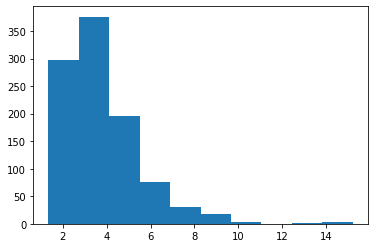

In [11]:
plt.hist(isi)

We can change the fineness of the binning by increasing or decreasing the number of bins:

(array([19., 30., 66., 92., 90., 81., 91., 77., 67., 60., 45., 52., 33.,
        33., 32., 17., 19., 15., 13., 12.,  4., 14.,  6.,  3.,  3.,  5.,
         5.,  3.,  1.,  3.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([ 1.35  ,  1.6272,  1.9044,  2.1816,  2.4588,  2.736 ,  3.0132,
         3.2904,  3.5676,  3.8448,  4.122 ,  4.3992,  4.6764,  4.9536,
         5.2308,  5.508 ,  5.7852,  6.0624,  6.3396,  6.6168,  6.894 ,
         7.1712,  7.4484,  7.7256,  8.0028,  8.28  ,  8.5572,  8.8344,
         9.1116,  9.3888,  9.666 ,  9.9432, 10.2204, 10.4976, 10.7748,
        11.052 , 11.3292, 11.6064, 11.8836, 12.1608, 12.438 , 12.7152,
        12.9924, 13.2696, 13.5468, 13.824 , 14.1012, 14.3784, 14.6556,
        14.9328, 15.21  ]),
 <a list of 50 Patch objects>)

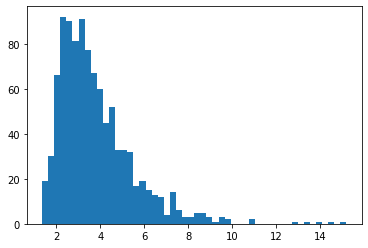

In [12]:
plt.hist(isi,50)

This can be used to empirically approximate a probability density function (pdf) by making sure it `integrates' to one.

Text(0, 0.5, 'pdf')

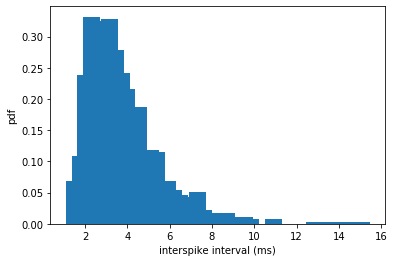

In [13]:
[xc,xe] = np.histogram(isi,50)
dx=xe[1]-xe[0]
xc=xc/dx/np.size(isi)
xcent=(xe[0:50]+xe[1:51])/2

plt.bar(xcent,xc)
plt.xlabel('interspike interval (ms)')         # label for x-axis
plt.ylabel('pdf')      # label for y-axis